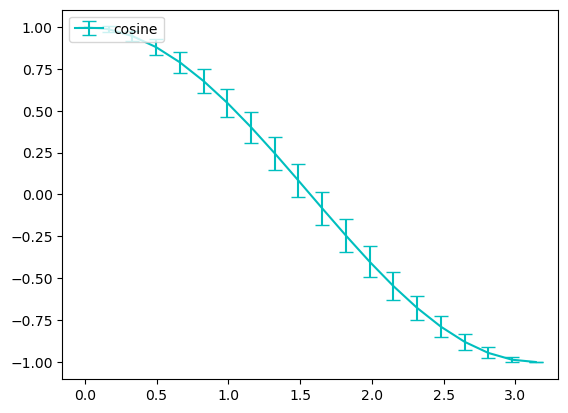

In [16]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(0, np.pi, 20, endpoint=True)
y = np.cos(X)
yy = np.abs(np.sin(X)/10)

plt.errorbar(X, y, yerr=yy, color='c', label='cosine', capsize=5)
plt.legend(loc='upper left')

In [ ]:
# 编码器部分
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    bn1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(bn1)
    bn1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    bn2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    bn2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    bn3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    bn3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    bn4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    bn4 = layers.BatchNormalization()(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    bn5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    bn5 = layers.BatchNormalization()(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # 解码器部分
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    bn6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    bn6 = layers.BatchNormalization()(conv6)

    up7 = layers.Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    bn7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    bn7 = layers.BatchNormalization()(conv7)

    up8 = layers.Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    bn8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    bn8 = layers.BatchNormalization()(conv8)

    up9 = layers.Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    bn9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    bn9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    bn9 = layers.BatchNormalization()(conv9)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(1, 2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)
